In [1]:
#주체는 승하차정류소임.
import pandas as pd

bus_train = pd.read_csv('/Users/mac/Documents/bus/train.csv')
bus_test = pd.read_csv('/Users/mac/Documents/bus/test.csv')

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
pip install xgboost

     |████████████████████████████████| 686kB 744kB/s eta 0:00:01
  Created wheel for xgboost: filename=xgboost-0.90-cp37-cp37m-macosx_10_9_x86_64.whl size=1710241 sha256=37b2e6c2cd83da5dd2b5190f832b5425aeb576abe12276b520a6e91d99aeea64
  Stored in directory: /Users/mac/Library/Caches/pip/wheels/e9/48/4d/de4187b5270dff71d3697c5a7857a1e2d9a0c63a28b3462eeb
Successfully built xgboost
Note: you may need to restart the kernel to use updated packages.


In [190]:
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)


In [371]:
pip install -U mlens

     |████████████████████████████████| 235kB 810kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [191]:
import gc
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Inputs
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


# Ensemble
from mlens.ensemble import SuperLearner

from scipy.stats import uniform, randint

from matplotlib.pyplot import show

# Model evaluation
from mlens.metrics import make_scorer
from mlens.model_selection import Evaluator


%matplotlib inline

[MLENS] backend: threading


In [3]:
bus_train.isnull().sum()

id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
18~20_ride       0
dtype: int64

In [4]:
#train에 하나더 많은 컬럼찾기= 구해야할값
temp3 = []
for i in bus_train.columns:
    if i not in bus_test.columns:
        temp3.append(i)

In [5]:
temp3  # 18~20_ride 타는사람예측

['18~20_ride']

In [6]:
bus_train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride'],
      dtype='object')

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

bus_nax=bus_train.dropna()
bus_nax.shape
bus_nax.describe

In [13]:
len(bus_train.id.unique())

415423

In [14]:
len(bus_train.bus_route_id.unique()) #버스루트개수

613

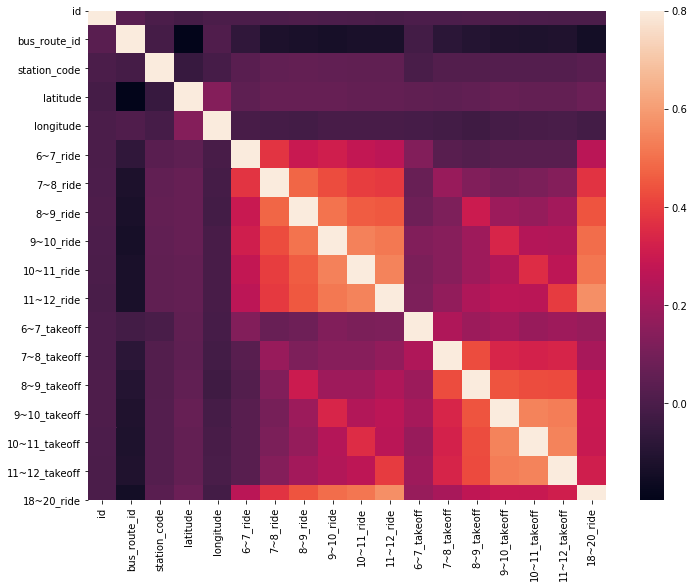

In [15]:
#correlation matrix
corrmat = bus_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [21]:
bus_train.loc[:,'date']

0         2019-09-01
1         2019-09-01
2         2019-09-01
3         2019-09-01
4         2019-09-01
             ...    
415418    2019-09-30
415419    2019-09-30
415420    2019-09-30
415421    2019-09-30
415422    2019-09-30
Name: date, Length: 415423, dtype: object

In [16]:
corrmat.loc[:,'18~20_ride'] > 0.5  #아침에 많이 출근을 했으니까 저녁에도 집갈때 많이이용했을듯

id               False
bus_route_id     False
station_code     False
latitude         False
longitude        False
6~7_ride         False
7~8_ride         False
8~9_ride         False
9~10_ride        False
10~11_ride        True
11~12_ride        True
6~7_takeoff      False
7~8_takeoff      False
8~9_takeoff      False
9~10_takeoff     False
10~11_takeoff    False
11~12_takeoff    False
18~20_ride        True
Name: 18~20_ride, dtype: bool

[0, 20, 0, 0.2]

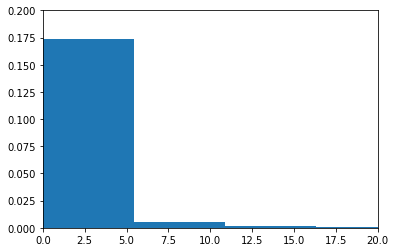

In [17]:
#histogram
n, bins, patches = plt.hist(bus_train['18~20_ride'], bins=50, density=True)
plt.axis([0, 20, 0, 0.2])

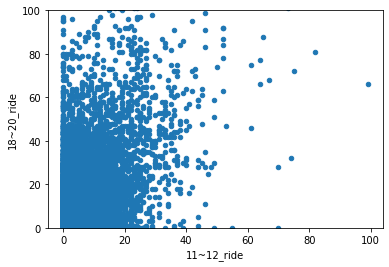

In [19]:
#bivariate analysis saleprice/grlivarea #도대체 무슨관계인건지...
var = '11~12_ride'
data = pd.concat([bus_train['18~20_ride'],bus_train[var]], axis=1)
data.plot.scatter(x=var, y='18~20_ride', ylim=(0,100));

In [28]:
bus_train_copy = bus_train.copy

In [37]:
bus_test.drop(['date', 'in_out', 'station_name'], axis='columns', inplace=True)

In [36]:
bus_train

,id,bus_route_id,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,4270000,344,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,4270000,357,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,4270000,432,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,4270000,1579,33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,4270000,1646,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,32820000,1129,33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415419,415419,32820000,1564,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415420,415420,32820000,2322,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
415421,415421,32820000,3291,33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [380]:
bus_test

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,415426,2019-10-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
4,415427,2019-10-01,4270000,시내,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,643588,2019-10-16,32820000,시내,786,고산환승정류장(고산1리),33.30073,126.18044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
228166,643589,2019-10-16,32820000,시내,1080,애월고등학교,33.46262,126.33447,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
228167,643590,2019-10-16,32820000,시내,1129,한림환승정류장(한림리),33.41437,126.26336,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228168,643591,2019-10-16,32820000,시내,1564,제주시외버스터미널,33.49946,126.51479,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
pip install geopy


SyntaxError: invalid syntax (<ipython-input-21-4c640d07c338>, line 1)

In [22]:
pip install folium

     |████████████████████████████████| 92kB 1.2MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [30]:
from collections import Counter # count 용도

In [23]:
import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용
# 해당 주요 장소의 임의 지역 위도, 경도(중급자코드참고)

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

#정류장의 위치만 확인하기 위해 groupby를 실행함
data=bus_train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm

In [27]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( bus_train['latitude'],bus_train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( bus_train['latitude'],bus_train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( bus_train['latitude'],bus_train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( bus_train['latitude'],bus_train['longitude'] )) ]

bus_train['dis_jeju']=t1
bus_train['dis_gosan']=t2
bus_train['dis_seongsan']=t3
bus_train['dis_po']=t4

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7

In [31]:
#4개의측정소중 어느측정소와 가까운지 계산
total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
bus_train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=bus_train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name'])



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Counter({'jeju': 1479, 'po': 828, 'gosan': 659, 'seongsan': 597})

In [33]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( bus_test['latitude'],bus_test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( bus_test['latitude'],bus_test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( bus_test['latitude'],bus_test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( bus_test['latitude'],bus_test['longitude'] )) ]

bus_test['dis_jeju']=t1
bus_test['dis_gosan']=t2
bus_test['dis_seongsan']=t3
bus_test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
bus_test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7

In [125]:
#날씨변수 전처리하기 unicode8문제해결할떄 encoding = ''CP949'' 붙여주기
raining = pd.read_csv('jejuweather.csv', encoding = 'CP949')

In [132]:
#외부데이터에서 나오는 지점명들을 변경
raining['지점'] = [str(i) for i in raining['지점']]

raining['지점'] = ['jeju' if i=='184' else i for i in raining['지점'] ]  # 위도 : 33.51411 경도 : 126.52969
raining['지점'] = ['gosan' if i=='185' else i for i in raining['지점'] ]  # 위도 : 33.29382 경도 : 126.16283
raining['지점'] = ['seongsan' if i=='188' else i for i in raining['지점'] ]  # 위도 : 33.38677 경도 : 126.8802
raining['지점'] = ['po' if i=='189' else i for i in raining['지점'] ]  # 위도 : 33.24616 경도 : 126.5653

raining.head()

,지점,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),풍향 QC플래그,적설(cm),3시간신적설(cm),전운량(10분위),중하층운량(10분위),운형(운형약어),최저운고(100m )
0,jeju,2019-09-01 01:00,23.7,NaN,NaN,NaN,2.1,NaN,180.0,NaN,NaN,NaN,10.0,9.0,NaN,73.0
1,jeju,2019-09-01 02:00,23.5,NaN,NaN,NaN,1.4,NaN,180.0,NaN,NaN,NaN,9.0,9.0,NaN,69.0
2,jeju,2019-09-01 03:00,23.4,NaN,NaN,NaN,1.1,NaN,180.0,NaN,NaN,NaN,8.0,5.0,ScCi,10.0
3,jeju,2019-09-01 04:00,23.4,NaN,NaN,NaN,1.6,NaN,180.0,NaN,NaN,NaN,10.0,6.0,ScAs,10.0
4,jeju,2019-09-01 05:00,23.3,NaN,NaN,NaN,1.2,NaN,180.0,NaN,NaN,NaN,10.0,6.0,ScAs,10.0


In [133]:
#일시와 시간을분리
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 

raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 

# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
rain2 = raining[ (raining['time']>=6) & (raining['time']<12)]

In [134]:
rain3 = rain2.groupby(['지점','일시'])[['기온(°C)','강수량(mm)']].mean()

rain3.to_csv("rain3.csv")

rain3=pd.read_csv("rain3.csv")

# train, test의 변수명과 통일시키고, NaN의 값은 0.0000으로 변경
rain3 = rain3.rename(columns={"일시":"date","지점":"dist_name"})
rain3= rain3.fillna(0.00000)

In [135]:
bus_train2=pd.merge(bus_train,rain3,how='left',on=['dist_name','date'])
bus_test2=pd.merge(bus_test,rain3,how='left',on=['dist_name','date'])

In [153]:
#승차,하차 시간대 통합작업(오전시간대 2시간간격으로 통합-busrget변수의 단위와 일치하게)
bus_train2['6~8_ride']=bus_train2['6~7_ride']+bus_train2['7~8_ride'] # 6 ~ 8시 승차인원
bus_train2['8~10_ride']=bus_train2['8~9_ride']+bus_train2['9~10_ride']
bus_train2['10~12_ride']=bus_train2['10~11_ride']+bus_train2['11~12_ride']

bus_train2['6~8_takeoff']=bus_train2['6~7_takeoff']+bus_train2['7~8_takeoff'] # 6 ~ 8시 하차인원
bus_train2['8~10_takeoff']=bus_train2['8~9_takeoff']+bus_train2['9~10_takeoff']
bus_train2['10~12_takeoff']=bus_train2['10~11_takeoff']+bus_train2['11~12_takeoff']

In [154]:
#승차,하차 시간대 통합작업(오전시간대 2시간간격으로 통합-busrget변수의 단위와 일치하게)
bus_test2['6~8_ride']=bus_test2['6~7_ride']+bus_test2['7~8_ride'] # 6 ~ 8시 승차인원
bus_test2['8~10_ride']=bus_test2['8~9_ride']+bus_test2['9~10_ride']
bus_test2['10~12_ride']=bus_test2['10~11_ride']+bus_test2['11~12_ride']

bus_test2['6~8_takeoff']=bus_test2['6~7_takeoff']+bus_test2['7~8_takeoff'] # 6 ~ 8시 하차인원
bus_test2['8~10_takeoff']=bus_test2['8~9_takeoff']+bus_test2['9~10_takeoff']
bus_test2['10~12_takeoff']=bus_test2['10~11_takeoff']+bus_test2['11~12_takeoff']

In [157]:
#요일뽑아내기 Monday is 0 and Sunday is 6.
bus_train2['date2'] = pd.to_datetime(bus_train2['date'])
bus_train2['weekday'] = bus_train2['date2'].dt.weekday

In [162]:
bus_test2['date2'] = pd.to_datetime(bus_test2['date'])
bus_test2['weekday'] = bus_test2['date2'].dt.weekday

In [202]:
#Feature Preparation #target: 18~20_ride
use_cols = [col for col in bus_train2.columns if col not in ['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff','id','station_name', 'bus_route_id','date','station_code','station_name','18~20_ride','date2']]
print(use_cols)

['in_out', 'latitude', 'longitude', 'dis_jejusi', 'dis_seoquipo', '6~8_ride', '8~10_ride', '10~12_ride', '6~8_takeoff', '8~10_takeoff', '10~12_takeoff', 'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po', 'dist_name', '기온(°C)', '강수량(mm)', 'weekday']


In [203]:
bus_train_use=bus_train2[use_cols]
bus_test_use=bus_test2[use_cols]

In [204]:
bus_train_use

,in_out,latitude,longitude,dis_jejusi,dis_seoquipo,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,기온(°C),강수량(mm),weekday
0,시외,33.48990,126.49373,2.954920,26.256744,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,jeju,24.650000,0.0,6
1,시외,33.48944,126.48508,3.720275,26.403025,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,jeju,24.650000,0.0,6
2,시외,33.48181,126.47352,5.036124,25.893305,2.0,2.0,0.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,jeju,24.650000,0.0,6
3,시내,33.50577,126.49252,2.864166,27.997494,17.0,32.0,30.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,jeju,24.650000,0.0,6
4,시내,33.25579,126.41260,29.040353,13.574693,0.0,0.0,0.0,0.0,1.0,0.0,30.652098,23.648361,45.899140,14.269792,po,23.783333,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,시내,33.41437,126.26336,25.950139,32.385460,4.0,0.0,0.0,0.0,0.0,0.0,27.117280,16.319339,57.465292,33.738981,gosan,23.866667,0.0,0
415419,시내,33.49946,126.51479,0.754801,26.927069,4.0,0.0,0.0,0.0,0.0,0.0,2.134693,39.904297,36.202951,28.484278,jeju,23.866667,0.0,0
415420,시내,33.23100,126.26273,38.482046,27.717482,0.0,0.0,0.0,1.0,0.0,0.0,40.039090,11.626985,60.041783,28.249863,gosan,23.866667,0.0,0
415421,시내,33.46483,126.31870,19.380000,31.873252,1.0,0.0,0.0,0.0,0.0,0.0,20.355649,23.876917,52.933244,33.392008,jeju,23.866667,0.0,0


In [205]:
categorical_feats = ['dist_name','in_out','weekday']

In [206]:
#원핫인코딩
from sklearn.preprocessing import LabelEncoder
for col in categorical_feats:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(bus_train_use[col].values.astype('str')) + list(bus_test_use[col].values.astype('str')))
    bus_train_use[col] = lbl.transform(list(bus_train_use[col].values.astype('str')))
    bus_test_use[col] = lbl.transform(list(bus_test_use[col].values.astype('str')))

dist_name
in_out
weekday


In [310]:
#원핫인코딩후 더미화
df_all = pd.concat([bus_train_use, bus_test_use])
df_all = pd.get_dummies(df_all, columns=categorical_feats)

In [311]:
df_all = df_all.rename(columns={"기온(°C)":"temp","강수량(mm)":"rain"})

In [312]:
numerical = ['latitude', 'longitude', 'dis_jejusi', 'dis_seoquipo', '6~8_ride',
       '8~10_ride', '10~12_ride', '6~8_takeoff', '8~10_takeoff',
       '10~12_takeoff', 'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po',
       'temp', 'rain']
             

In [313]:
df_all= df_all.fillna(0.00000)

In [314]:
df_all

,latitude,longitude,dis_jejusi,dis_seoquipo,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,...,dist_name_3,in_out_0,in_out_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,33.48990,126.49373,2.954920,26.256744,1.0,7.0,8.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,33.48944,126.48508,3.720275,26.403025,5.0,6.0,11.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,33.48181,126.47352,5.036124,25.893305,2.0,2.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
3,33.50577,126.49252,2.864166,27.997494,17.0,32.0,30.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
4,33.25579,126.41260,29.040353,13.574693,0.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,33.30073,126.18044,31.886351,42.908345,0.0,0.0,0.0,3.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
228166,33.46262,126.33447,17.496654,33.837570,0.0,0.0,0.0,1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
228167,33.41437,126.26336,24.109523,38.714956,3.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
228168,33.49946,126.51479,0.768583,26.867858,3.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0


In [315]:
#보류(정규화까지 해내기)
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
print(robustScaler.fit(df_all[numerical]))
train_data_robustScaled = robustScaler.transform(df_all[numerical])

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)


In [362]:
x=pd.DataFrame(train_data_robustScaled,columns=['latitude', 'longitude', 'dis_jejusi', 'dis_seoquipo', '6~8_ride',
       '8~10_ride', '10~12_ride', '6~8_takeoff', '8~10_takeoff',
       '10~12_takeoff', 'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po',
       'temp', 'rain'])


In [363]:
x_left=df_all[df_all.columns.difference(numerical)]

In [368]:
#왠지모르겠지만... 이렇게하니까 concat가 됨...
df = pd.concat([x, x_left], axis=1, join_axes=[x_left.index])

In [366]:
x_left

,dist_name_0,dist_name_1,dist_name_2,dist_name_3,in_out_0,in_out_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,1,0,0,0,1,0,0,0,0,0,0,1
1,0,1,0,0,0,1,0,0,0,0,0,0,1
2,0,1,0,0,0,1,0,0,0,0,0,0,1
3,0,1,0,0,1,0,0,0,0,0,0,0,1
4,0,0,1,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,1,0,0,0,1,0,0,0,1,0,0,0,0
228166,0,1,0,0,1,0,0,0,1,0,0,0,0
228167,1,0,0,0,1,0,0,0,1,0,0,0,0
228168,0,1,0,0,1,0,0,0,1,0,0,0,0


In [370]:
#정규화된걸로 교체
df_all = df

In [371]:
#전처리후 다시 나눠주기
len_train = bus_train_use.shape[0] #shape의 첫번째는 열의 수를 나타냄
print(len_train)
len_test = bus_test_use.shape[0]
print(len_test)
train = df_all[:len_train]
test = df_all[len_train:]

415423
228170


In [305]:
len_test = bus_test_use.shape[0]
print(len_test)

228170


In [306]:
#전처리후 다시 나눠주기
train = df_all[:len_train]
test = df_all[len_train:]

In [372]:
target = bus_train['18~20_ride']

In [373]:
#light gbm 장점: gbm의 느린속도를 보완, gpu지원 leaf-wise한 분석방법(불필요한 작업을 최소화함)
#n_estimators: 반복하려는 트리의개수
#learning_rate: 학습률  
#min_child_samples: 리프노드가 되기위한 최소한의 샘플수
#feature_fraction: 트리를학습할떄마다 선택하는 feature의 비율
#leg_lambda: l2 regulation 
#leg_alpha: l1 regulation 

lgb_params = {"objective" : "regression", "metric" : "rmse", 
               "max_depth": 7, "min_child_samples": 20, 
               "reg_alpha": 1, "reg_lambda": 1,
               "num_leaves" : 64, "learning_rate" : 0.001, 
               "subsample" : 0.8, "colsample_bytree" : 0.8, 
               "verbosity": -1}

FOLDs = KFold(n_splits=5, shuffle=True, random_state=1989)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

features_lgb = list(train.columns)
feature_importance_df_lgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train)):
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])

    print("LGB " + str(fold_) + "-" * 50)
    num_round = 2000
    clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 2000)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df_lgb = pd.DataFrame()
    fold_importance_df_lgb["feature"] = features_lgb
    fold_importance_df_lgb["importance"] = clf.feature_importance()
    fold_importance_df_lgb["fold"] = fold_ + 1
    feature_importance_df_lgb = pd.concat([feature_importance_df_lgb, fold_importance_df_lgb], axis=0)
    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / FOLDs.n_splits
    

print(np.sqrt(mean_squared_error(oof_lgb, target)))

LGB 0--------------------------------------------------
Training until validation scores don't improve for 2000 rounds
[200]	training's rmse: 4.26522	valid_1's rmse: 4.51265
[400]	training's rmse: 3.94005	valid_1's rmse: 4.21764
[600]	training's rmse: 3.68571	valid_1's rmse: 3.98396
[800]	training's rmse: 3.48667	valid_1's rmse: 3.79865
[1000]	training's rmse: 3.3315	valid_1's rmse: 3.65548
[1200]	training's rmse: 3.21122	valid_1's rmse: 3.54635
[1400]	training's rmse: 3.11759	valid_1's rmse: 3.46295
[1600]	training's rmse: 3.04295	valid_1's rmse: 3.3985
[1800]	training's rmse: 2.98336	valid_1's rmse: 3.34682
[2000]	training's rmse: 2.93487	valid_1's rmse: 3.30448
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 2.93487	valid_1's rmse: 3.30448
LGB 1--------------------------------------------------
Training until validation scores don't improve for 2000 rounds
[200]	training's rmse: 4.27052	valid_1's rmse: 4.43714
[400]	training's rmse: 3.94839	valid_1's rmse: 4.

In [233]:
print('lgb', np.sqrt(mean_squared_error(oof_lgb, target)))

lgb 3.094541565285531


In [374]:
#xgboost
import xgboost as xgb

xgb_params = {'eta': 0.001, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}



FOLDs = KFold(n_splits=5, shuffle=True, random_state=1989)

oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))


for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train)):
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 2000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=100, verbose_eval=200)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb += xgb_model.predict(xgb.DMatrix(test), ntree_limit=xgb_model.best_ntree_limit+50) / FOLDs.n_splits

np.sqrt(mean_squared_error(oof_xgb, target))

xgb 0--------------------------------------------------
[0]	train-rmse:4.73179	valid-rmse:4.94188
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:4.27365	valid-rmse:4.53699
[400]	train-rmse:3.9156	valid-rmse:4.22634
[600]	train-rmse:3.63211	valid-rmse:3.98506
[800]	train-rmse:3.41084	valid-rmse:3.80149
[1000]	train-rmse:3.23608	valid-rmse:3.6588
[1200]	train-rmse:3.09823	valid-rmse:3.55051
[1400]	train-rmse:2.9887	valid-rmse:3.4658
[1600]	train-rmse:2.901	valid-rmse:3.39973
[1800]	train-rmse:2.83029	valid-rmse:3.34767
[1999]	train-rmse:2.77311	valid-rmse:3.30478
xgb 1--------------------------------------------------
[0]	train-rmse:4.73663	valid-rmse:4.92304
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:4.28673	valid-rmse:4.4676
[400]	train-rmse:3.93368	vali

3.0609423259134885

In [375]:
#두번째 223등
print('lgb', np.sqrt(mean_squared_error(oof_lgb, target)))
print('xgb', np.sqrt(mean_squared_error(oof_xgb, target)))

lgb 3.0938322040915507
xgb 3.0609423259134885


In [442]:
#첫번쨰 250등
print('lgb', np.sqrt(mean_squared_error(oof_lgb, target)))
print('xgb', np.sqrt(mean_squared_error(oof_xgb, target)))

lgb 3.452483719007316
xgb 3.445217373357728


In [443]:
total_sum = 0.5 * oof_lgb + 0.5 * oof_xgb
print("CV score: {:<8.5f}".format(mean_squared_error(total_sum, target)**0.5))

CV score: 3.44625 


In [379]:
df_all.columns

Index(['latitude', 'longitude', 'dis_jejusi', 'dis_seoquipo', '6~8_ride',
       '8~10_ride', '10~12_ride', '6~8_takeoff', '8~10_takeoff',
       '10~12_takeoff', 'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po',
       'temp', 'rain', 'dist_name_0', 'dist_name_1', 'dist_name_2',
       'dist_name_3', 'in_out_0', 'in_out_1', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [386]:
target

0          0.0
1          5.0
2          2.0
3         53.0
4          0.0
          ... 
415418     0.0
415419     0.0
415420     0.0
415421     0.0
415422     0.0
Name: 18~20_ride, Length: 415423, dtype: float64

In [389]:
input_var = ['latitude', 'longitude', 'dis_jejusi', 'dis_seoquipo', '6~8_ride',
       '8~10_ride', '10~12_ride', '6~8_takeoff', '8~10_takeoff',
       '10~12_takeoff', 'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po',
       'temp', 'rain', 'dist_name_0', 'dist_name_1', 'dist_name_2',
       'dist_name_3', 'in_out_0', 'in_out_1', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
target = ['18~20_ride']

In [382]:
import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링


In [393]:
test[input_var]

,latitude,longitude,dis_jejusi,dis_seoquipo,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,...,dist_name_3,in_out_0,in_out_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0.053301,-0.360004,-0.329749,-0.011011,1.0,7.0,8.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,0,0
1,0.051110,-0.446409,-0.298107,0.006422,5.0,6.0,11.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,0,0
2,0.014766,-0.561882,-0.243707,-0.054324,2.0,2.0,0.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,0,0
3,0.128894,-0.372091,-0.333501,0.196440,17.0,32.0,30.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
4,-1.061827,-1.170413,0.748681,-1.522380,0.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,0.012003,0.753971,-0.122565,-0.162388,1.0,0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
228166,0.101076,-0.156128,-0.418570,0.076103,0.0,0.0,0.0,0.0,3.0,1.0,...,0,1,0,0,0,1,0,0,0,0
228167,0.128608,-0.365398,-0.336079,0.194052,0.0,2.0,1.0,0.0,14.0,4.0,...,0,1,0,0,0,1,0,0,0,0
228168,0.096266,0.005794,-0.421548,0.040444,1.0,6.0,2.0,1.0,2.0,7.0,...,0,1,0,0,0,1,0,0,0,0


In [395]:
train

,latitude,longitude,dis_jejusi,dis_seoquipo,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,...,dist_name_3,in_out_0,in_out_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0.053301,-0.360004,-0.329749,-0.011011,1.0,7.0,8.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,0.051110,-0.446409,-0.298107,0.006422,5.0,6.0,11.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,0.014766,-0.561882,-0.243707,-0.054324,2.0,2.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
3,0.128894,-0.372091,-0.333501,0.196440,17.0,32.0,30.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
4,-1.061827,-1.170413,0.748681,-1.522380,0.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,-0.306469,-2.661173,0.620925,0.719371,4.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0
415419,0.098838,-0.149635,-0.420706,0.068874,4.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0
415420,-1.179909,-2.667466,1.139022,0.163070,0.0,0.0,0.0,1.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0
415421,-0.066114,-2.108381,0.349301,0.658329,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0


In [403]:
target

['18~20_ride']

In [402]:
train

,latitude,longitude,dis_jejusi,dis_seoquipo,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,...,dist_name_3,in_out_0,in_out_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0.053301,-0.360004,-0.329749,-0.011011,1.0,7.0,8.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,0.051110,-0.446409,-0.298107,0.006422,5.0,6.0,11.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,0.014766,-0.561882,-0.243707,-0.054324,2.0,2.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
3,0.128894,-0.372091,-0.333501,0.196440,17.0,32.0,30.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
4,-1.061827,-1.170413,0.748681,-1.522380,0.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,-0.306469,-2.661173,0.620925,0.719371,4.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0
415419,0.098838,-0.149635,-0.420706,0.068874,4.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0
415420,-1.179909,-2.667466,1.139022,0.163070,0.0,0.0,0.0,1.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0
415421,-0.066114,-2.108381,0.349301,0.658329,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0


In [409]:
train2=pd.concat([train, bus_train[target]],axis=1)

In [410]:
train2

,latitude,longitude,dis_jejusi,dis_seoquipo,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,...,in_out_0,in_out_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,18~20_ride
0,0.053301,-0.360004,-0.329749,-0.011011,1.0,7.0,8.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0.0
1,0.051110,-0.446409,-0.298107,0.006422,5.0,6.0,11.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,5.0
2,0.014766,-0.561882,-0.243707,-0.054324,2.0,2.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,2.0
3,0.128894,-0.372091,-0.333501,0.196440,17.0,32.0,30.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,53.0
4,-1.061827,-1.170413,0.748681,-1.522380,0.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,0,0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,-0.306469,-2.661173,0.620925,0.719371,4.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,0,0,0,0,0.0
415419,0.098838,-0.149635,-0.420706,0.068874,4.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,0,0,0,0,0.0
415420,-1.179909,-2.667466,1.139022,0.163070,0.0,0.0,0.0,1.0,0.0,0.0,...,1,0,1,0,0,0,0,0,0,0.0
415421,-0.066114,-2.108381,0.349301,0.658329,1.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,0,0,0,0,0.0


In [416]:
X_train=train2[input_var]

In [421]:
#rf로
X_train=train2[input_var]
random.seed(1217) #동일한 샘플링하기 위한 시드번호
train_list=random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)) )

X_train=train2[input_var]
X_train=X_train.iloc[train_list,:]
y_train=train2[target]
y_train=y_train.iloc[train_list,:]

X_test=test[input_var]

X_train.shape, y_train.shape

((4154, 29), (4154, 1))

In [423]:
test

,latitude,longitude,dis_jejusi,dis_seoquipo,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,...,in_out_0,in_out_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,18~20_ride
0,0.053301,-0.360004,-0.329749,-0.011011,1.0,7.0,8.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,4.719752
1,0.051110,-0.446409,-0.298107,0.006422,5.0,6.0,11.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,6.708236
2,0.014766,-0.561882,-0.243707,-0.054324,2.0,2.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,1.657543
3,0.128894,-0.372091,-0.333501,0.196440,17.0,32.0,30.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,26.640849
4,-1.061827,-1.170413,0.748681,-1.522380,0.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,1,0,0,0,0,0,0.414584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,0.012003,0.753971,-0.122565,-0.162388,1.0,0.0,1.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0.374226
228166,0.101076,-0.156128,-0.418570,0.076103,0.0,0.0,0.0,0.0,3.0,1.0,...,1,0,0,0,1,0,0,0,0,0.431387
228167,0.128608,-0.365398,-0.336079,0.194052,0.0,2.0,1.0,0.0,14.0,4.0,...,1,0,0,0,1,0,0,0,0,2.324104
228168,0.096266,0.005794,-0.421548,0.040444,1.0,6.0,2.0,1.0,2.0,7.0,...,1,0,0,0,1,0,0,0,0,4.996483


In [427]:
sub

,id,18~20_ride
0,415423,5.652159
1,415424,8.289497
2,415425,1.209236
3,415426,32.836373
4,415427,0.277858
...,...,...
228165,643588,0.547528
228166,643589,0.479003
228167,643590,2.258382
228168,643591,4.234344


In [428]:
rf = RandomForestRegressor(max_features=3,min_samples_leaf=2,min_samples_split=2,n_estimators=500,random_state=1217)

rf.fit(X_train,y_train) #학습 

test['18~20_ride'] = rf.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.
#해당 코드 소요 시간 5분


In [429]:
test['18~20_ride']

0          4.719752
1          6.708236
2          1.657543
3         26.640849
4          0.414584
            ...    
228165     0.374226
228166     0.431387
228167     2.324104
228168     4.996483
228169     0.353000
Name: 18~20_ride, Length: 228170, dtype: float64

In [425]:
sub = pd.read_csv('/Users/mac/Documents/bus/submission_sample.csv')
sub["18~20_ride"] = 0.5 * predictions_lgb + 0.5 * predictions_xgb
sub[['id','18~20_ride']].to_csv("sub_dacon.csv",index=False)

In [482]:
df_all_id=pd.concat([bus_train.id, bus_test.id], axis=0)

In [487]:
df_allandid=pd.concat([df_all_id, df_all], axis=1)
df_allandid.groupby(df_allandid['id']).mean()

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,in_out_0,in_out_1
id,,,,,,,,,,,,,,
0,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1,0
643589,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
643590,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [489]:
df_allandid.iloc[df_allandid.id=415424,:]

SyntaxError: invalid syntax (<ipython-input-489-f460b653088b>, line 1)

In [8]:
#전처리했지만 노쓸모 

bus_train

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,시내,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415419,415419,2019-09-30,32820000,시내,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415420,415420,2019-09-30,32820000,시내,2322,해병부대,33.23100,126.26273,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
415421,415421,2019-09-30,32820000,시내,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
bus_groupby=bus_train.groupby(bus_train['id']).mean()

In [26]:
bus_sub = pd.read_csv('/Users/mac/Documents/bus/bus_bts.csv')


In [74]:
bus_train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride'],
      dtype='object')

In [111]:
#여기서부터 작업(12.07기준)
time=bus_sub.geton_time.str[0:2]

In [112]:
time.unique()

array(['06', '07', '09', '08', '10', '11'], dtype=object)

In [127]:
#bus_sub 탑승시간별로 factor형 변수로 선언
time[time=='06']='6~7_ride'
time[time=='07']='7~8_ride'
time[time=='08']='8~9_ride'
time[time=='09']='9~10_ride'
time[time=='10']='10~11_ride'
time[time=='11']='11~12_ride'

In [115]:
timeoff=bus_sub.getoff_time.str[0:2]

In [190]:
#bus_sub 하차시간별로 factor형 변수로 선언
timeoff[timeoff=='06']='6~7_takeoff'
timeoff[timeoff=='07']='7~8_takeoff'
timeoff[timeoff=='08']='8~9_takeoff'
timeoff[timeoff=='09']='9~10_takeoff'
timeoff[timeoff=='10']='10~11_takeoff'
timeoff[timeoff=='11']='11~12_takeoff'
timeoff[timeoff=='12']='12~13_takeoff'
timeoff[timeoff=='13']='13~14_takeoff'
timeoff[timeoff=='14']='14~15_takeoff'
timeoff[timeoff=='15']='15~16_takeoff'

In [249]:
bus_sub_time=pd.concat([bus_sub, timeon,timeoff], axis=1)

In [166]:
bus_train

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,시내,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415419,415419,2019-09-30,32820000,시내,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415420,415420,2019-09-30,32820000,시내,2322,해병부대,33.23100,126.26273,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
415421,415421,2019-09-30,32820000,시내,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [250]:
#col명변경
bus_sub_time.columns.values[13]='geton_cl'
bus_sub_time.columns.values[14]='getoff_cl'

In [251]:
#col제거
bus_sub_time.drop(['geton_time', 'getoff_time'], axis='columns', inplace=True)

In [252]:
#pivot으로 train데이터형태로 변환해줌
bus_sub_time_geton=pd.pivot_table(bus_sub_time,index=['user_card_id','bus_route_id'],columns=['geton_cl'],aggfunc='mean')
bus_sub_time_getoff=pd.pivot_table(bus_sub_time,index=['user_card_id','bus_route_id'],columns=['getoff_cl'],aggfunc='mean')

In [280]:
bus_sub_time_geton_count=bus_sub_time_geton['user_count']

In [320]:
bus_sub_time_getoff_count=bus_sub_time_getoff['user_count']

In [321]:
bus_sub_time_getoff_count

getoff_cl                  10~11_takeoff  11~12_takeoff  12~13_takeoff  \
user_card_id bus_route_id                                                
1.526841e+08 21230000                NaN            NaN            NaN   
2.245620e+08 23580000                1.0            NaN            NaN   
             31600000                NaN            1.0            NaN   
2.751194e+08 22180000                1.0            NaN            NaN   
             24030000                NaN            NaN            NaN   
...                                  ...            ...            ...   
1.000700e+19 31600000                NaN            2.0            NaN   
             28690000                1.0            NaN            NaN   
             23220000                NaN            NaN            NaN   
             23490000                NaN            NaN            NaN   
             21480000                NaN            NaN            NaN   

getoff_cl                  13~14_takeoff  14~15_takeoff  15~16_takeoff  \
user_card_id bus_route_id                                                
1.526841e+08 21230000                NaN            NaN            NaN   
2.245620e+08 23580000                NaN            NaN            NaN   
             31600000                NaN            NaN            NaN   
2.751194e+08 22180000                NaN            NaN            NaN   
             24030000                NaN            NaN            NaN   
...                                  ...            ...            ...   
1.000700e+19 31600000                NaN            NaN            NaN   
             28690000                NaN            NaN            NaN   
             23220000                NaN            NaN            NaN   
             23490000                NaN            NaN            NaN   
             21480000                NaN            NaN            NaN   

getoff_cl                  6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  
user_card_id bus_route_id                                                       
1.526841e+08 21230000              NaN          NaN          NaN           1.0  
2.245620e+08 23580000              NaN          NaN          NaN           NaN  
             31600000              NaN          NaN          NaN           NaN  
2.751194e+08 22180000              NaN          NaN          NaN           NaN  
             24030000              NaN          NaN          1.0           NaN  
...                                ...          ...          ...           ...  
1.000700e+19 31600000              NaN          NaN          NaN           NaN  
             28690000              NaN          NaN          NaN           NaN  
             23220000              NaN          NaN          1.0           NaN  
             23490000              NaN          NaN          NaN           1.0  
             21480000              NaN          NaN          1.0           NaN  

[839783 rows x 10 columns]

In [271]:
#pivot데이터의 index확인
bus_sub_time_getoff_count.index

MultiIndex([(           152684084.0, 21230000),
            (           224562029.0, 23580000),
            (           224562029.0, 31600000),
            (           275119437.0, 22180000),
            (           275119437.0, 24030000),
            (           275119437.0, 31830000),
            (           275211981.0, 32310000),
            (           275403789.0, 23610000),
            (           331913485.0, 28720000),
            (           485489604.0, 28510000),
            ...
            (    9700395000807642.0, 28490000),
            (    9700395000807642.0, 21270000),
            (1.0007001000003457e+19,  8170000),
            (1.0007001000019247e+19, 21520000),
            (1.0007001000021498e+19, 21010000),
            (1.0007001000025678e+19, 31600000),
            (1.0007001000025678e+19, 28690000),
            (1.0007001000025678e+19, 23220000),
            (1.0007001010010534e+19, 23490000),
            (1.0007003010023143e+19, 21480000)],
           names=['user

In [322]:
# 1,2번쨰 index를 지워줌
bus_sub_time_getoff_count.reset_index(level=[0,1],inplace=True)

In [323]:
bus_sub_time_getoff_count

getoff_cl,user_card_id,bus_route_id,10~11_takeoff,11~12_takeoff,12~13_takeoff,13~14_takeoff,14~15_takeoff,15~16_takeoff,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff
0,1.526841e+08,21230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2.245620e+08,23580000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.245620e+08,31600000,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.751194e+08,22180000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.751194e+08,24030000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
839778,1.000700e+19,31600000,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
839779,1.000700e+19,28690000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
839780,1.000700e+19,23220000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
839781,1.000700e+19,23490000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [325]:
bus_sub_time_getoff_count = pd.DataFrame(bus_sub_time_getoff_count)
print(bus_sub_time_getoff_count)

getoff_cl  user_card_id  bus_route_id  10~11_takeoff  11~12_takeoff  \
0          1.526841e+08      21230000            NaN            NaN   
1          2.245620e+08      23580000            1.0            NaN   
2          2.245620e+08      31600000            NaN            1.0   
3          2.751194e+08      22180000            1.0            NaN   
4          2.751194e+08      24030000            NaN            NaN   
...                 ...           ...            ...            ...   
839778     1.000700e+19      31600000            NaN            2.0   
839779     1.000700e+19      28690000            1.0            NaN   
839780     1.000700e+19      23220000            NaN            NaN   
839781     1.000700e+19      23490000            NaN            NaN   
839782     1.000700e+19      21480000            NaN            NaN   

getoff_cl  12~13_takeoff  13~14_takeoff  14~15_takeoff  15~16_takeoff  \
0                    NaN            NaN            NaN            NaN   
1

In [326]:
#geton 전처리
bus_sub_time_geton_count
# 1,2번쨰 index를 지워줌
bus_sub_time_geton_count.reset_index(level=[0,1],inplace=True)
bus_sub_time_geton_count = pd.DataFrame(bus_sub_time_geton_count)
print(bus_sub_time_geton_count)

geton_cl  user_card_id  bus_route_id  10~11_ride  11~12_ride  6~7_ride  \
0         1.355555e+07       4280000         NaN         1.0       NaN   
1         1.745600e+07      23610000         1.0         NaN       NaN   
2         1.180404e+08      23710000         1.0         NaN       NaN   
3         1.526841e+08      21230000         NaN         NaN       NaN   
4         2.245620e+08      23580000         1.0         NaN       NaN   
...                ...           ...         ...         ...       ...   
1178577   1.000700e+19      21420000         NaN         1.0       NaN   
1178578   1.000700e+19      23490000         NaN         NaN       NaN   
1178579   1.000700e+19      24280000         NaN         NaN       NaN   
1178580   1.000700e+19      31320000         NaN         NaN       NaN   
1178581   1.000700e+19      21480000         NaN         NaN       NaN   

geton_cl  7~8_ride  8~9_ride  9~10_ride  
0              NaN       NaN        NaN  
1              NaN       Na

In [364]:
#fullouter join  bus_sub_time_geton_count를 기준으로하기(null이 없으므로)
bus_sub_time_getonoff = pd.merge(bus_sub_time_geton_count,bus_sub_time_getoff_count, how='outer',on='user_card_id',indicator=True)

In [361]:
bus_sub_time_getonoff

,user_card_id,bus_route_id_x,10~11_ride,11~12_ride,6~7_ride,7~8_ride,8~9_ride,9~10_ride,bus_route_id_y,10~11_takeoff,11~12_takeoff,12~13_takeoff,13~14_takeoff,14~15_takeoff,15~16_takeoff,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,_merge
0,1.355555e+07,4280000,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,1.745600e+07,23610000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,1.180404e+08,23710000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,1.526841e+08,21230000,NaN,NaN,NaN,1.0,NaN,NaN,21230000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,both
4,2.245620e+08,23580000,1.0,NaN,NaN,NaN,NaN,NaN,23580000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6827539,1.000700e+19,21420000,NaN,1.0,NaN,NaN,NaN,NaN,23490000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,both
6827540,1.000700e+19,23490000,NaN,NaN,NaN,NaN,1.0,NaN,23490000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,both
6827541,1.000700e+19,24280000,NaN,NaN,NaN,NaN,NaN,1.0,23490000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,both
6827542,1.000700e+19,31320000,NaN,NaN,NaN,NaN,NaN,1.0,23490000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,both


In [359]:
bus_sub_time_getonoff

,user_card_id,bus_route_id_x,10~11_takeoff,11~12_takeoff,12~13_takeoff,13~14_takeoff,14~15_takeoff,15~16_takeoff,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,bus_route_id_y,10~11_ride,11~12_ride,6~7_ride,7~8_ride,8~9_ride,9~10_ride,_merge
0,1.526841e+08,21230000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,21230000,NaN,NaN,NaN,1.0,NaN,NaN,both
1,2.245620e+08,23580000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23580000,1.0,NaN,NaN,NaN,NaN,NaN,both
2,2.245620e+08,23580000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31600000,NaN,1.0,NaN,NaN,NaN,NaN,both
3,2.245620e+08,31600000.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23580000,1.0,NaN,NaN,NaN,NaN,NaN,both
4,2.245620e+08,31600000.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31600000,NaN,1.0,NaN,NaN,NaN,NaN,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6827539,9.700395e+15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23230000,NaN,NaN,NaN,NaN,NaN,1.0,right_only
6827540,9.700395e+15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24030000,NaN,NaN,NaN,1.0,1.0,NaN,right_only
6827541,9.700395e+15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25050000,NaN,NaN,NaN,NaN,1.0,NaN,right_only
6827542,9.700395e+15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31630000,NaN,NaN,NaN,NaN,1.0,NaN,right_only
